In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'

# увеличим дефолтный размер графиков

from pylab import rcParams

rcParams["figure.figsize"] = 10, 6

In [2]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
q = '''
    SELECT 
        count(*) 
    FROM 
        ldn_listings 
    '''
        

# отправляем запрос и записываем результат в пандасовский датафрейм
ldn_listings = ph.read_clickhouse(query=q, connection=connection_default)
ldn_listings

,count()
0,85207


In [4]:
q = '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
    FROM 
        ldn_listings
    ORDER BY id
    LIMIT 1000
    '''
ldn_listings_price = ph.read_clickhouse(query=q, connection=connection_default)
ldn_listings_price

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


In [5]:
ldn_listings_price.groupby('room_type').quantile(q=0.75) 

,price
room_type,
Entire home/apt,160.00
Hotel room,157.00
Private room,70.00
Shared room,69.25


In [6]:
q = '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
        toFloat32OrNull(review_scores_rating) as review_scores_rating
    FROM 
        ldn_listings
    WHERE 
        review_scores_rating IS NOT NULL
    ORDER BY id
    LIMIT 1000
    '''
ldn_price_rating = ph.read_clickhouse(query=q, connection=connection_default)
ldn_price_rating

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0
...,...,...,...
995,Entire home/apt,165.0,100.0
996,Private room,99.0,93.0
997,Private room,45.0,100.0
998,Private room,20.0,88.0


In [7]:
ldn_price_rating_mean = ldn_price_rating.groupby('room_type').agg({'price' : 'mean', 'review_scores_rating' : 'mean'})

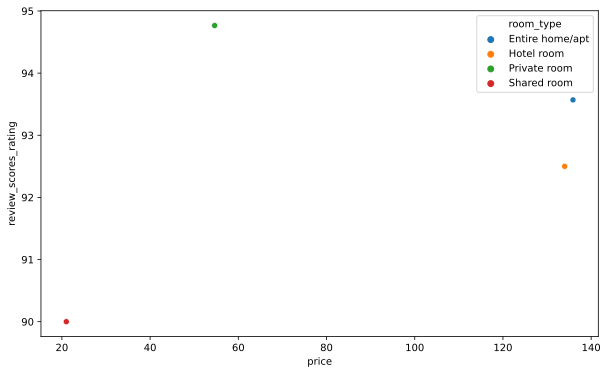

In [8]:
sns.scatterplot(data=ldn_price_rating_mean, x="price", y="review_scores_rating", hue="room_type");

In [9]:
q = '''
    SELECT DISTINCT
        host_id,
        host_verifications
    FROM 
        default.ldn_listings
    WHERE 
        experiences_offered != 'none'
    '''
ldn_verifications = ph.read_clickhouse(query=q, connection=connection_default)
ldn_verifications

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [10]:
ldn_verifications['host_verifications'] = ldn_verifications.host_verifications.apply(lambda x: x.strip('[]').replace("'", "").split(","))

In [11]:
ldn_verifications_exp = ldn_verifications.explode('host_verifications')

In [12]:
ldn_verifications_exp.value_counts('host_verifications')

host_verifications
email                     1345
 phone                    1345
 reviews                  1309
 government_id            1196
 jumio                    1115
 offline_government_id     469
 work_email                279
 facebook                  270
 selfie                    252
 identity_manual           227
 manual_offline             70
 google                     34
 kba                        27
phone                       16
 manual_online              16
 sent_id                     6
dtype: int64

In [13]:
q = '''
    SELECT 
        neighbourhood_cleansed,
        experiences_offered,
        count(*) as experiences_count
    FROM 
        default.ldn_listings
    WHERE 
        experiences_offered != 'none'
    GROUP BY 
        neighbourhood_cleansed,
        experiences_offered
    ORDER BY  
        experiences_count DESC  
    LIMIT 100
    '''
ldn_experiences = ph.read_clickhouse(query=q, connection=connection_default)
ldn_experiences

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [14]:
ldn_experiences_pivot = ldn_experiences.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')

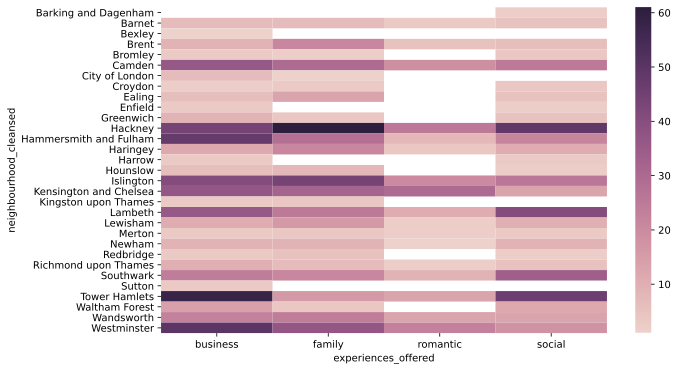

In [15]:
sns.heatmap(ldn_experiences_pivot, cmap=sns.cubehelix_palette(as_cmap=True));

In [16]:
q = '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
    FROM 
        default.ldn_listings
    WHERE 
        experiences_offered != 'none'
    ORDER BY  
        price DESC 
    '''
ldn_price = ph.read_clickhouse(query=q, connection=connection_default)
ldn_price

,room_type,price
0,Entire home/apt,1500.0
1,Entire home/apt,1200.0
2,Entire home/apt,999.0
3,Entire home/apt,901.0
4,Entire home/apt,735.0
...,...,...
1543,Private room,15.0
1544,Private room,15.0
1545,Private room,15.0
1546,Private room,15.0


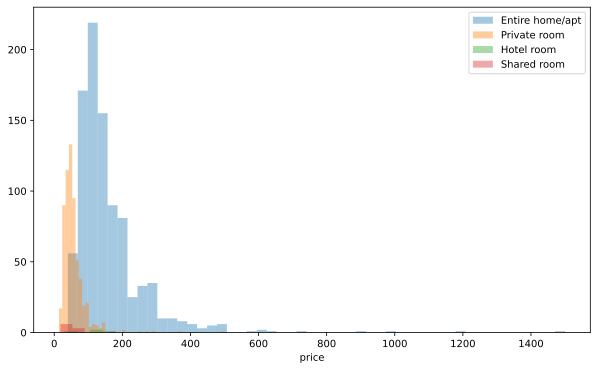

In [23]:
sns.distplot(ldn_price.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(ldn_price.query("room_type=='Private room'").price, kde=False, label='Private room')
sns.distplot(ldn_price.query("room_type=='Hotel room'").price, kde=False, label='Hotel room')
sns.distplot(ldn_price.query("room_type=='Shared room'").price, kde=False, label='Shared room')
plt.legend()
plt.show()

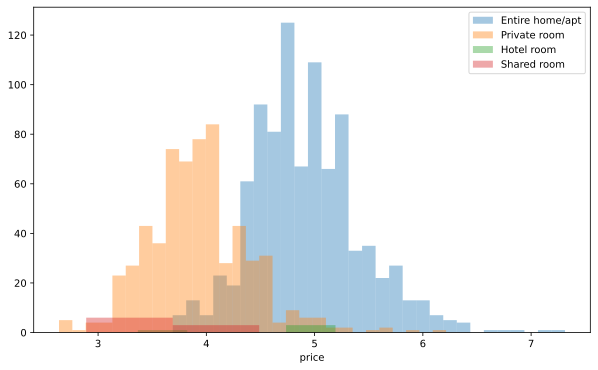

In [26]:
sns.distplot(np.log(ldn_price.query("room_type=='Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(ldn_price.query("room_type=='Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(ldn_price.query("room_type=='Hotel room'").price), kde=False, label='Hotel room')
sns.distplot(np.log(ldn_price.query("room_type=='Shared room'").price), kde=False, label='Shared room')
plt.legend()
plt.show()

In [27]:
q = '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
        first_review
    FROM 
        default.ldn_listings
    WHERE 
        first_review > '2010-01-01'
    LIMIT 1000
    '''
ldn_review = ph.read_clickhouse(query=q, connection=connection_default)
ldn_review

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [30]:
ldn_review['first_review'] = ldn_review.first_review.apply(lambda x: x.split('-')[0])

In [31]:
ldn_review

,room_type,price,first_review
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010
...,...,...,...
995,Private room,45.0,2012
996,Private room,51.0,2013
997,Entire home/apt,79.0,2012
998,Entire home/apt,110.0,2012


In [40]:
ldn_review_avg = ldn_review.groupby(['room_type', 'first_review']).agg({'price' : 'mean'}).round().sort_values('first_review')

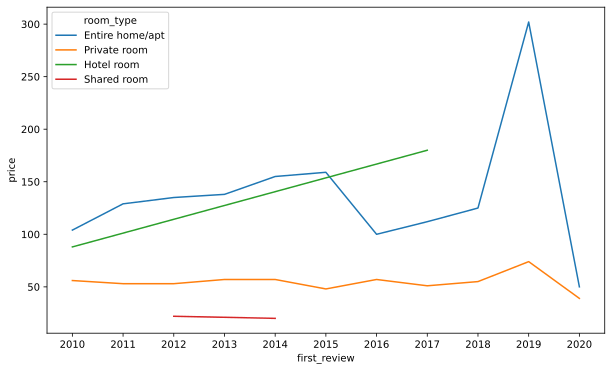

In [41]:
sns.lineplot(x='first_review',y='price',hue='room_type',data=ldn_review_avg)